In [1]:
# in this session, we add batch normalization to further improve performance

In [2]:
import random
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

seed = 2147483647
random.seed(seed)

In [3]:
words = open('names.csv', 'r').read().splitlines()
words = [s.lower() for s in words] # adding special char to start/end names '.'
words[:10]

['aaban',
 'aabha',
 'aabid',
 'aabidah',
 'aabir',
 'aabriella',
 'aada',
 'aadam',
 'aadan',
 'aadarsh']

In [4]:
# learning some statistical properties about the dataset
len(words), min(len(w) for w in words), max(len(w) for w in words)

(101338, 2, 15)

In [5]:
#build vocabulary
special_token = '.'
def vocabulary(words):
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi[special_token] = 0
    itos = {i:s for s,i in stoi.items()}
    return stoi, itos, len(itos)

stoi, itos, vocab_size = vocabulary(words)
special_idx = stoi[special_token]

itos #confirm dictionary makes sense

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [6]:
# build dataset
block_size = 3 #how many chars to use in our prediction

def build_dataset(words):
    X, Y = [], [] #inputs and labels

    for w in words:
        context = [special_idx] * block_size #context starts as ". . ."
        for ch in w + special_token:
            ix = stoi[ch] # retrieve index for char from vocab
            X.append(context) #add current example, starting with ". . ."
            Y.append(ix) #the label is the next char (or first, or . for last)
            context = context[1:] + [ix] #cropping first char as window slides and another char is added

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'{X.shape=}, {Y.shape=}')
    
    return X, Y

random.seed(seed)
random.shuffle(words)

train=0.8
dev=0.1
assert train + dev <= 1

n1 = int(train*len(words))
n2 = int((train+dev)*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

X.shape=torch.Size([609946, 3]), Y.shape=torch.Size([609946])
X.shape=torch.Size([76390, 3]), Y.shape=torch.Size([76390])
X.shape=torch.Size([76486, 3]), Y.shape=torch.Size([76486])


In [7]:
# MLP
g = torch.Generator().manual_seed(seed) # for reproducibility

class MLP():
    def __init__(self, vocab, block_size, n_embd=10, n_hidden=200):
        self.vocab_size = len(vocab)
        self.block_size = block_size
        self.C = torch.randn((vocab_size, n_embd),               generator=g)
        # n_embd * block size is the dim so the actual embeddings can be shaped to match it
        # W1 is normalized with sqrt dim 0; 5/3 is from https://arxiv.org/abs/1502.03167
        self.W1_norm = (5/3)/((n_embd * block_size)**0.5) 
        self.W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * self.W1_norm
        # we ignore b1 because batch norm comes with a bias param already, bnbias
        # self.b1 = torch.randn(n_hidden,                          generator=g) * 0.01
        self.W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
        self.b2 = torch.randn(vocab_size,                        generator=g) * 0.01

        # batch norm parameters
        self.bngain = torch.ones((1, n_hidden)) #start with meaningless gain *1
        self.bnbias = torch.zeros((1, n_hidden)) #start with meaningless bias +0

        # not really parameters, used at inference
        self.bnstd_running = torch.ones((1, n_hidden))
        self.bnmean_running = torch.zeros((1, n_hidden))

        self.parameters = [self.C, self.W1, self.W2, self.b2, self.bngain, self.bnbias]
        print(sum(p.nelement() for p in self.parameters))

        #turn on grads
        for p in self.parameters:
            p.requires_grad = True

    def forward(self, X, Y):
        emb = self.C[X] #embed characters into vectors
        embcat = emb.view(-1, self.W1.shape[0]) #flatten and reshape so it can matmul W1
        #linear layer
        hpreact = embcat @ self.W1 #hidden_pre_activation

        #batch norm layer
        bnmeani = hpreact.mean(0, keepdim=True) #averaging across all examples in batch, keeping n_hidden dim
        bnstdi = hpreact.std(0, keepdim=True) #std across all examples in batch, keeping n_hidden dim
        #remove mean, normalize over std, multiply by batchnorm gain and add batchnorm bias
        hpreact = self.bngain * (hpreact - bnmeani) / bnstdi + self.bnbias

        #non linear layer
        h = torch.tanh(hpreact) #hidden layer
        logits = h @ self.W2 + self.b2 #output layer
        self.loss = F.cross_entropy(logits, Y) #loss

        # for use during inference
        with torch.no_grad():
            self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * bnmeani
            self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * bnstdi

        return self.loss
    
    def backward(self, lr=0.1):
        for p in self.parameters: p.grad=None
        self.loss.backward()
        for p in self.parameters: p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def generate(self, q=20):
        for _ in range(q):
            out = []
            context = [0] * self.block_size # initialize as <special> * block_size
            while True:
                #forward pass, same as above
                emb = self.C[torch.tensor([context])] #(1 example, block_size chars, emb_depth))
                embcat = emb.view(-1, self.W1.shape[0])
                hpreact = embcat @ self.W1

                # THIS WAS NON-OBVIOUS
                # =============================
                # for inference we use bmean_running and bnstd_running
                # because the ith values don't make sense for a single example
                hpreact = self.bngain * (hpreact-self.bnmean_running)/self.bnstd_running + self.bnbias
                # =============================

                h = torch.tanh(hpreact) #hidden layer
                logits = h @ self.W2 + self.b2 #output layer

                #sample from probabilities
                probs = F.softmax(logits, dim=1)
                
                ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
                context = context[1:] + [ix] #keep shifting context (the input)
                out.append(ix)
                if ix == 0:
                    break
            print(''.join(itos[i] for i in out))



In [8]:
n_embd = 10
n_hidden = 200
model = MLP(stoi, block_size, n_embd, n_hidden)

12097


In [9]:
#stats
lri = []
lossi = []
stepi = []

# trainer
start_time = time.time()
steps = 200_000
batch_size = 256 #batches smaller than 1024 are faster on my CPU than GPU
lre = torch.linspace(-0.5, -3.5, steps) #decaying learning rate
lrs = 10**lre

for i in range(steps):
    # make a list of random integers between 0 and size of Xtr to select for each batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch
    # forward pass
    loss = model.forward(Xb, Yb)

    # backward pass
    model.backward(lrs[i])

    # stats
    lossi.append(loss.log10().item())
    if i % (steps/20) == 0:
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')

elapsed_time = time.time() - start_time
print("Total time: {:.2f} seconds".format(elapsed_time))

      0/ 200000: 3.3048
  10000/ 200000: 2.3650
  20000/ 200000: 2.2029
  30000/ 200000: 2.2879
  40000/ 200000: 2.1688
  50000/ 200000: 2.0660
  60000/ 200000: 2.1378
  70000/ 200000: 2.2150
  80000/ 200000: 2.1587
  90000/ 200000: 2.2142
 100000/ 200000: 2.0933
 110000/ 200000: 2.1304
 120000/ 200000: 2.2208
 130000/ 200000: 2.2380
 140000/ 200000: 2.0691
 150000/ 200000: 1.9615
 160000/ 200000: 2.1896
 170000/ 200000: 2.1033
 180000/ 200000: 2.1478
 190000/ 200000: 2.0667
Total time: 136.33 seconds


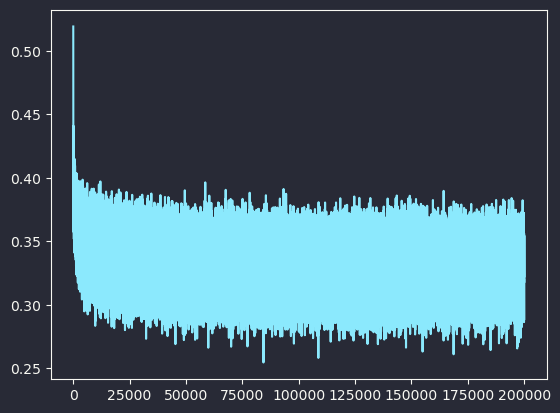

In [10]:
plt.plot(lossi)

In [11]:
# calculate loss, bnmean, bnstd across the whole training set
with torch.no_grad():
    loss_tr = model.forward(Xtr, Ytr)
    loss_dev = model.forward(Xdev, Ydev)

print(f'{loss_tr=}, {loss_dev=}')

loss_tr=tensor(2.1229), loss_dev=tensor(2.1375)


In [12]:
# loss and results about the same as vanilla MLP
model.generate()

lardleylee.
moni.
lilin.
amartherrio.
dia.
jayzaeson.
zakeishelmerelle.
shyuna.
shawn.
alli.
mair.
tyrah.
freed.
travellamaiya.
brandis.
yuley.
tomanic.
card.
adria.
man.


In [55]:
# next step is to ppytorchify the whole thing and improve debugging
# first we define classes for each type of layer

# torch.set_grad_enabled(True)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        #trainable parameters
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        #this is the same as a forward pass, but now can be called directly as object(X)
        self.out = x @ self.weight
        #self.out.retain_grad()
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] # + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # trainable parameters
        self.gamma = torch.ones(dim) #this is a scaling factor, starts as neutral X*1
        self.beta = torch.zeros(dim) #this is similar to a bias, starts as neutral X+1
        # buffers that keep running averages
        self.running_var = torch.ones(dim) # for gamma
        self.running_mean = torch.zeros(dim) # for beta
        
    def __call__(self, x):
        #forward pass
        if self.training:
            # during training we normalize each batch by removing its mean and dividing by std
            xvar = x.var(0, keepdims=True) 
            xmean = x.mean(0, keepdim=True) #mean across batch examples
            #update buffers for inference
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        else:
            # during inference, the batch is n=1, so removing mean would zero the matrix and std=0
            xvar = self.running_var
            xmean = self.running_mean

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #epsilon so var is never 0
        self.out = self.gamma * xhat + self.beta
        #self.out.retain_grad()
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        #self.out.retain_grad()
        return self.out
    def parameters(self):
        return []
    

g = torch.Generator().manual_seed(seed)

class MLP_batchnorm:
    def __init__(self, vocab_size, block_size=3, n_embd=10, n_hidden=120):
        self.n_embd = n_embd
        self.n_hidden = n_hidden
        self.vocab_size = vocab_size
        self.block_size = block_size
        # the actual model is built by stacking layers
        # this version has a lot more layers
        self.C = torch.randn((vocab_size,n_embd), generator=g)
        self.layers = [
            Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            Linear(         n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            Linear(         n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            Linear(         n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            Linear(         n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            Linear(         n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
        ]

        # tweak some relative importance of layers
        with torch.no_grad():
            # make last layer less confident
            self.layers[-1].gamma *= 0.1
            # all other layers, apply gain
            for layer in self.layers[:-1]:
                if isinstance(layer, Linear):
                    layer.weight *= 5/3 # from https://arxiv.org/abs/1502.03167

        self.parameters = [self.C] + [p for layer in self.layers for p in layer.parameters()]
        print( sum(p.nelement() for p in self.parameters) ) #total number of parameters

        # turn on autograd
        for p in self.parameters:
            p.requires_grad = True

        # for layer in self.layers:
        #     layer.out.retain_grad() #this is due to some bug I yet don't understand

    def __call__(self, x, y):
        # forward pass
        emb = self.C[x]
        #assert self.C.requires_grad == True
        #assert emb.requires_grad == True

        x = emb.view(emb.shape[0], -1) #flatten into 2D
        #assert x.requires_grad

        for layer in self.layers:
            x = layer(x)
            #assert x.requires_grad
        
        self.out = x
        self.loss = F.cross_entropy(x, y)
        #assert self.loss.requires_grad
        return x, self.loss
    
    def backward(self, lr=0.1):
        for layer in self.layers:
            layer.out.retain_grad() #this is due to some bug I yet don't understand
        
        # clear grads
        for p in self.parameters: p.grad = None
        self.loss.backward()
        #update params
        for p in self.parameters: p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def generate(self, q=20):
        # there should be a better API for this
        for layer in self.layers:
            layer.training = False
        for _ in range(q):
            out = []
            context = [0] * self.block_size # initialize as <special> * block_size
            while True:
                #forward pass, same as above
                emb = self.C[torch.tensor([context])] #(1 example, block_size chars, emb_depth))
                x = emb.view(emb.shape[0], -1)
                for layer in self.layers:
                    x = layer(x)
                logits = x
                probs = F.softmax(logits, dim=1)
                
                ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
                context = context[1:] + [ix] #keep shifting context (the input)
                out.append(ix)
                if ix == 0:
                    break
            print(''.join(itos[i] for i in out))

model = MLP_batchnorm(vocab_size)
            

173724


In [56]:
#stats
lossi = []
ud = []

# trainer
start_time = time.time()
steps = 50_000
batch_size = 64 #batches smaller than 1024 are faster on my CPU than GPU
# lre = torch.linspace(-0.5, -3.5, steps) #decaying learning rate
lre = torch.linspace(-0.5, -2, steps)
lrs = 10**lre

for i in range(steps):
    # make a list of random integers between 0 and size of Xtr to select for each batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch
    # forward pass
    output, loss = model(Xb, Yb)
    # assert loss.requires_grad == True

    # backward pass
    model.backward(lrs[i])
    # assert model.loss.requires_grad == True

    # stats
    lossi.append(loss.log10().item())
    if i % (steps/20) == 0:
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')

    with torch.no_grad():
        ud.append([( (lrs[i]*p.grad).std() / p.data.std()).log10().item() for p in model.parameters])

assert model.loss.requires_grad == True
elapsed_time = time.time() - start_time
print("Total time: {:.2f} seconds".format(elapsed_time))


      0/  50000: 3.3012
   2500/  50000: 2.2498
   5000/  50000: 2.4493
   7500/  50000: 2.1119
  10000/  50000: 1.9885
  12500/  50000: 2.3339
  15000/  50000: 2.3054
  17500/  50000: 2.2271
  20000/  50000: 2.2971
  22500/  50000: 2.2167
  25000/  50000: 2.1530
  27500/  50000: 2.4164
  30000/  50000: 2.2532
  32500/  50000: 2.0162
  35000/  50000: 2.0245
  37500/  50000: 2.3530
  40000/  50000: 1.9055
  42500/  50000: 2.0342
  45000/  50000: 1.9961
  47500/  50000: 2.1601
Total time: 134.35 seconds


layer 2 Tanh: mean=-7.4089e-03, std=6.4871e-01 saturated: 11.94%
layer 5 Tanh: mean=3.3292e-03, std=6.7242e-01 saturated: 14.59%
layer 8 Tanh: mean=6.7235e-03, std=6.8114e-01 saturated: 14.62%
layer 11 Tanh: mean=-8.5599e-03, std=6.9493e-01 saturated: 12.73%
layer 14 Tanh: mean=2.1455e-04, std=7.0551e-01 saturated: 10.62%


Text(0.5, 1.0, 'activation distribution')

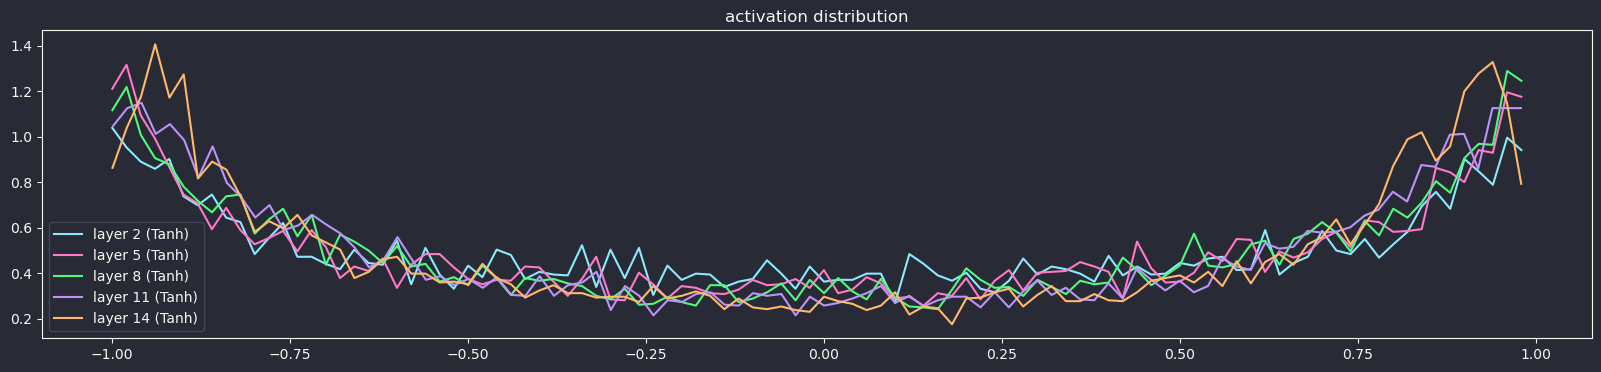

In [57]:
#visualize 
# the purpose of this visualization is to look at the parameters for each Tanh layer
# and make sure it hasn't been saturated. Tanh must be between -1 and 1, so at thos values
# it will saturate and we start losing information.
# we are also looking to confirm each layer maintains a similar distribution
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(model.layers[:-1]): #exclude output
    if isinstance(layer, Tanh):
        t=layer.out
        name = layer.__class__.__name__
        mean = t.mean().item()
        std = t.std().item()
        sat = (t.abs() > 0.97).sum() / t.size()[0] 

        print(f'layer {i} {name}: {mean=:.4e}, {std=:.4e} saturated: {sat:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({name})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 | Tanh | mean=2.7649e-12 | std=1.2249e-03
layer 5 | Tanh | mean=-8.0036e-13 | std=1.2337e-03
layer 8 | Tanh | mean=-1.0914e-12 | std=1.2817e-03
layer 11 | Tanh | mean=1.0914e-12 | std=1.2130e-03
layer 14 | Tanh | mean=-1.4552e-12 | std=1.1120e-03


Text(0.5, 1.0, 'gradient distribution')

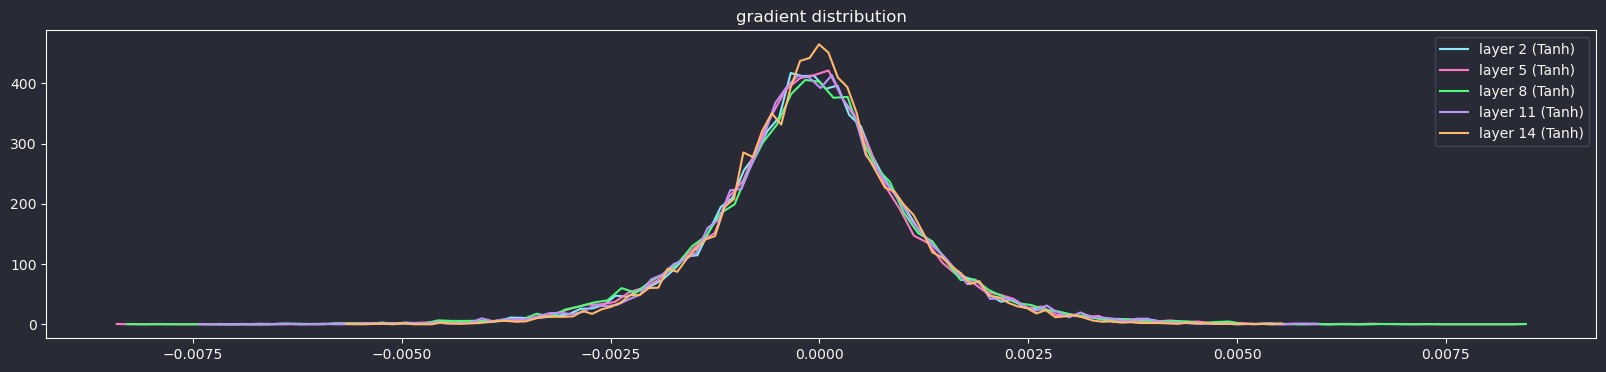

In [58]:
# visualize the distribution of the gradient
# we want the gradient to be distributed around 0, and to stay the same between layers
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(model.layers[:-1]): #exclude output
    if isinstance(layer, Tanh):
        t=layer.out.grad
        name = layer.__class__.__name__
        mean = t.mean().item()
        std = t.std().item()
        # sat = (t.abs() > 0.97).sum() / t.size()[0]

        print(f'layer {i} | {name} | {mean=:.4e} | {std=:.4e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({name})')
plt.legend(legends)
plt.title('gradient distribution')

weight=(27, 10) | mean=-3.1044e-10 | std=1.0174e-02 | ratio_grad_data=9.9756e-03
weight=(30, 200) | mean=1.9082e-05 | std=4.3162e-03 | ratio_grad_data=1.3383e-02
weight=(200, 200) | mean=-1.2662e-05 | std=2.9572e-03 | ratio_grad_data=2.2476e-02
weight=(200, 200) | mean=-8.1884e-06 | std=3.1237e-03 | ratio_grad_data=2.4045e-02
weight=(200, 200) | mean=9.0400e-06 | std=2.9552e-03 | ratio_grad_data=2.2825e-02
weight=(200, 200) | mean=1.6062e-05 | std=2.5991e-03 | ratio_grad_data=2.0418e-02
weight=(200, 27) | mean=8.0001e-06 | std=5.8131e-03 | ratio_grad_data=3.2797e-02


Text(0.5, 1.0, 'weights gradient distribution')

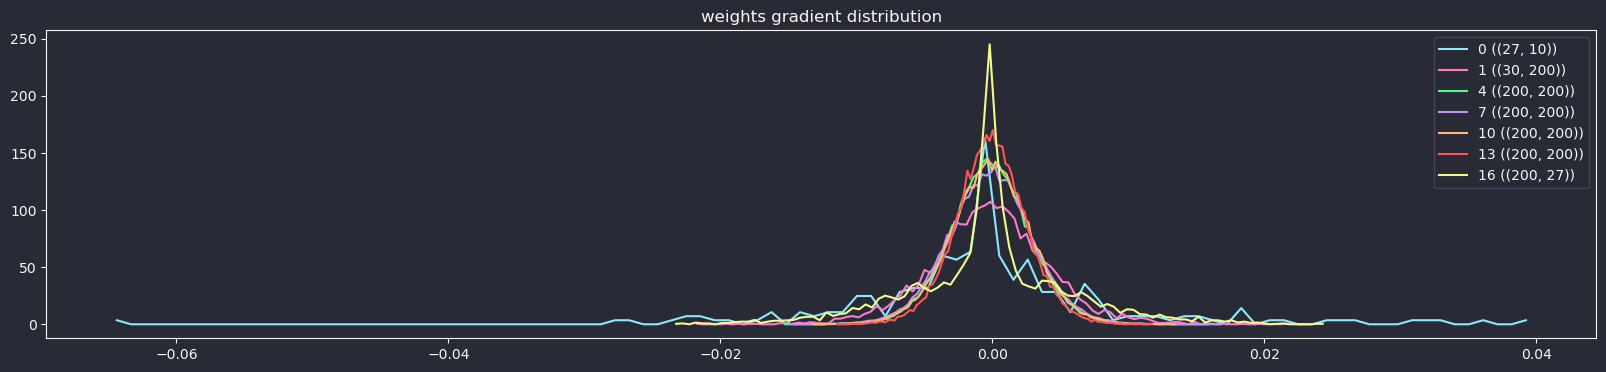

In [59]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(model.parameters): 
    t=p.grad
    if p.ndim == 2:
        weight = tuple(p.shape)
        mean = t.mean()
        std = t.std()
        ratio_grad_data = std / p.std()
        print(f'{weight=} | {mean=:.4e} | {std=:.4e} | {ratio_grad_data=:.4e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} ({weight})')
plt.legend(legends)
plt.title('weights gradient distribution')

Text(0.5, 1.0, 'gradient distribution')

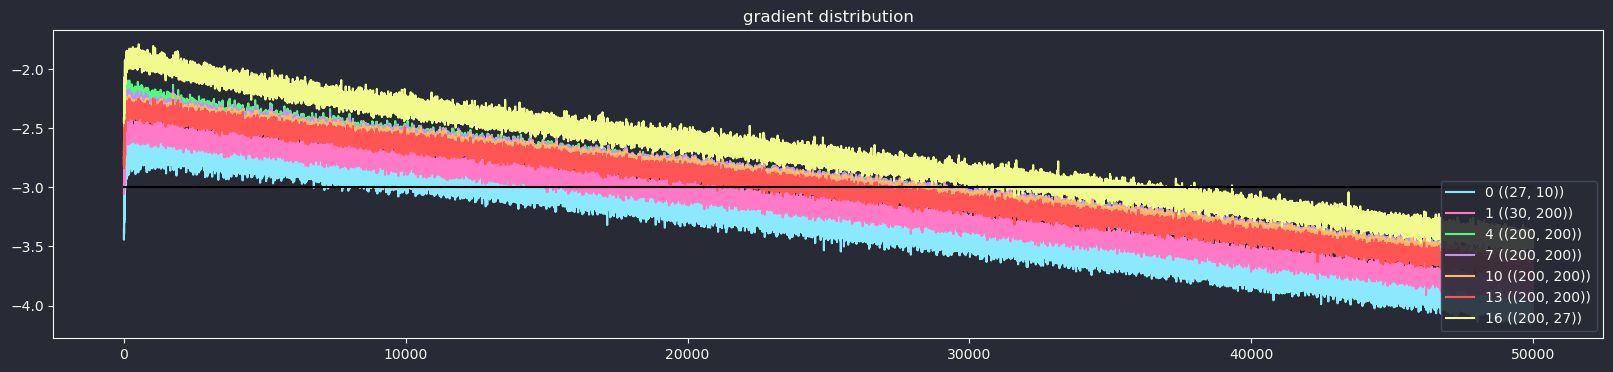

In [60]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(model.parameters): 
    if p.ndim == 2:
        weight = tuple(p.shape)
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'{i} ({weight})')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends, loc='lower right')
plt.title('gradient distribution')

In [61]:
# calculate loss, bnmean, bnstd across the whole training set
# WARNING, running this inside torch.no_grad() drops all the gradients
# put layers into eval mode
for layer in model.layers:
  layer.training = False

with torch.no_grad():
    _, loss_tr = model(Xtr, Ytr)
    _, loss_dev = model(Xdev, Ydev)

print(f'{loss_tr=}, {loss_dev=}')

loss_tr=tensor(2.1030), loss_dev=tensor(2.1236)


In [62]:
# slightly better loss is apparent in results
model.generate()

ramili.
hastina.
abellena.
thell.
maryn.
aesleigh.
zagnaz.
corlanikki.
aariya.
ayus.
dey.
jadian.
keona.
phenissandra.
wilevolyn.
mira.
sha.
marianez.
arilhames.
derine.
